In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
"""

Components to build

    Vanilla decoder model
    XL Transformer model
    kNN memory (add/remove functionality)
    kNN attention layer
    T5 relative position bias

    "We used a 12-layer decoder-only transformer (with and without Transformer-XL cache) with an embedding size of 1024, 8 attention heads of dimension 128, and an FFN hidden layer of size 4096. For all of our experiments, we used k = 32. Unless specified otherwise, we use the 9th layer as the kNN augmented attention layer. We used a sentence-piece (Kudo & Richardson, 2018) tokenizer with a vocabulary size of 32K."
"""

'\n\nComponents to build\n\n    Vanilla decoder model\n    XL Transformer model\n    kNN memory (add/remove functionality)\n    kNN attention layer\n    T5 relative position bias\n\n    "We used a 12-layer decoder-only transformer (with and without Transformer-XL cache) with an embedding size of 1024, 8 attention heads of dimension 128, and an FFN hidden layer of size 4096. For all of our experiments, we used k = 32. Unless specified otherwise, we use the 9th layer as the kNN augmented attention layer. We used a sentence-piece (Kudo & Richardson, 2018) tokenizer with a vocabulary size of 32K."\n'

# Single head attention

In [3]:
# Sample number
sequence_length = 512
embedding_dimension = 300
head_dimension = 32
number_heads = 8
batch_size = 16
scaling_factor = head_dimension ** -0.5

In [4]:
# Single batch fake training data
input_data=torch.randn(sequence_length, embedding_dimension)
input_data.shape

torch.Size([512, 300])

In [5]:
# KQ transforms
query_matrix=nn.Linear(embedding_dimension,number_heads*head_dimension)
key_matrix=nn.Linear(embedding_dimension,number_heads*head_dimension)
value_matrix=nn.Linear(embedding_dimension,number_heads*head_dimension)

In [6]:
query_matrix 

Linear(in_features=300, out_features=256, bias=True)

In [7]:
# Create KQV matrices  with input data
queries = query_matrix(input_data)
keys = key_matrix(input_data)
values = value_matrix(input_data)

In [8]:
queries.shape

torch.Size([512, 256])

In [9]:
keys.shape

torch.Size([512, 256])

In [10]:
keys=keys.transpose(-1, -2)
keys.shape

torch.Size([256, 512])

In [11]:
qk = queries @ keys
qk.shape

torch.Size([512, 512])

In [12]:
qk=qk/torch.sqrt(torch.tensor(256))

In [13]:
dim=271
a = torch.randn(5*dim,dim)
b=torch.randn(dim,5*dim)
ab=a@b

In [14]:
a.var()

tensor(0.9947)

In [15]:
ab.var()

tensor(268.7509)

In [16]:
ab=ab/((dim)**.5)

In [17]:
ab.var()

tensor(0.9917)

In [18]:
ab.norm()

tensor(1349.3293)

In [19]:
a.norm()

tensor(604.3724)

In [20]:
my_data=torch.tensor([1.,.9,.7,1.2])
torch.nn.functional.softmax(my_data,dim=-1)

tensor([0.2586, 0.2340, 0.1916, 0.3158])

In [21]:
labels = ["A", "DOG", "IS", "AN", "ANIMAL"]
toy_qk = torch.tensor([[.900, 0.300, 0.00, 0.100, 0.000],
        [0.600, 2.00, 0.100, 0.2000, 1.9000],
        [0.00, 0.200, 1.00, 0.100, 0.0500],
        [0.0500, 0.0000, 0.100, 0.9500, .5000],
        [0.000, 1.8000, 0.0000, .4000, 2.1000]])

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def attention_plot(qk, labels, title=None):
    
    plt.figure(figsize=(8,6))
    im =plt.imshow(qk, cmap="Greens")
    
    plt.xticks(ticks=np.arange(qk.shape[0]), labels=labels)
    plt.yticks(ticks=np.arange(qk.shape[0]), labels=labels)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    
    # Adding x and y axis labels with a bigger font size
    plt.xlabel("KEYS", fontsize=4, labelpad=20) # X-axis label at the top
    plt.ylabel('QUERIES', fontsize=14)
    plt.title(title,fontsize=20)
    
    #adjust the position of the x-axis label to the top
    plt.gca().xaxis.set_label_position('top')
                                       
    for i in range(qk.shape[0]):
        for j in range(qk.shape[1]):
                                       
            text=plt.text(j, i, f'{qk[i,j]:.2f}',
                         ha="center",va="center",color="b")
    # Adding a colorbar
    plt.colorbar(im)
                                       
    #Displaying the plot
    plt.show()

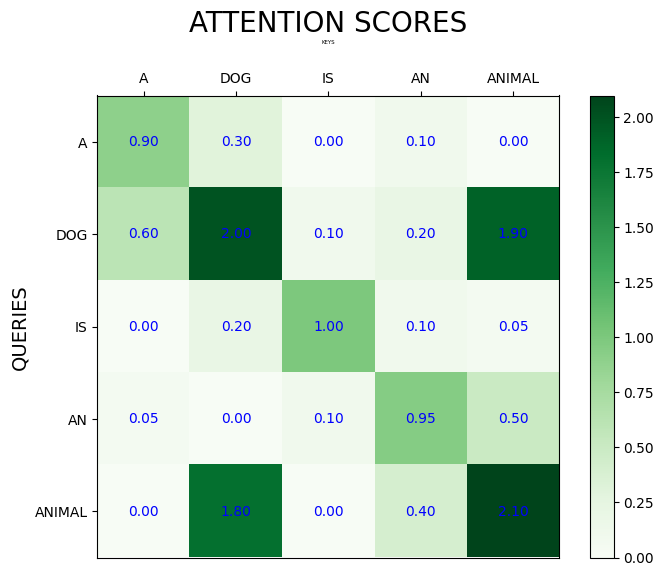

In [24]:
#OK
attention_plot(toy_qk, labels,"ATTENTION SCORES")

In [25]:
j,i=5,5
mask = torch.ones((j,i), dtype=torch.bool)
mask

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])

In [26]:
mask=mask.triu(1)

In [27]:
mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [28]:
toy_qk_masked=toy_qk.masked_fill(mask,float('-inf'))

In [29]:
toy_qk_masked

tensor([[0.9000,   -inf,   -inf,   -inf,   -inf],
        [0.6000, 2.0000,   -inf,   -inf,   -inf],
        [0.0000, 0.2000, 1.0000,   -inf,   -inf],
        [0.0500, 0.0000, 0.1000, 0.9500,   -inf],
        [0.0000, 1.8000, 0.0000, 0.4000, 2.1000]])

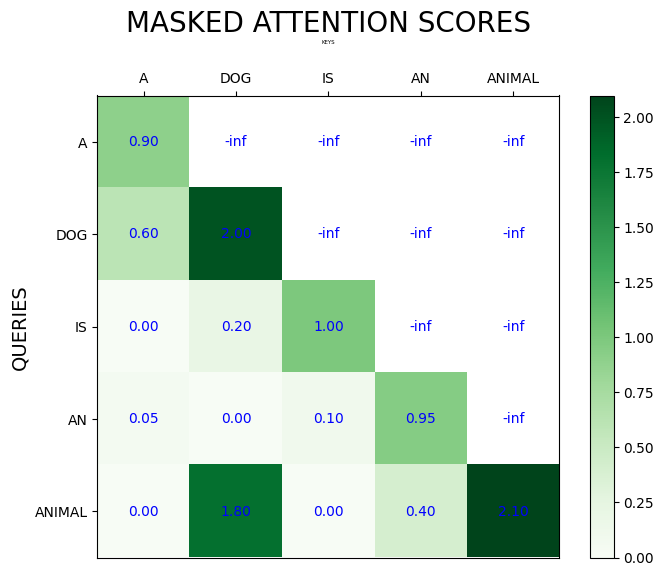

In [30]:
attention_plot(toy_qk_masked, labels,"MASKED ATTENTION SCORES")

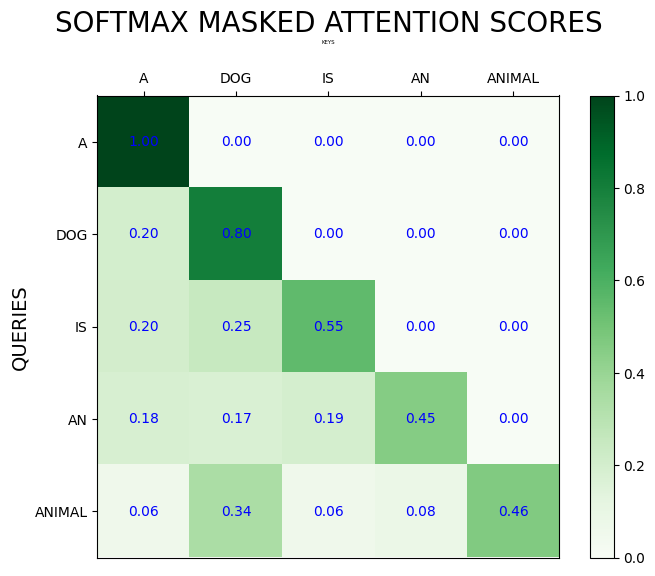

In [31]:
#Apply SOFTMAX
toy_qk_softmax=torch.nn.functional.softmax(toy_qk_masked, dim=-1)
attention_plot(toy_qk_softmax,labels,"SOFTMAX MASKED ATTENTION SCORES")

In [32]:
#last row
toy_qk_softmax[-1]

tensor([0.0565, 0.3416, 0.0565, 0.0842, 0.4612])

In [33]:
# "A"  "DOG" "IS"  "AN" "ANIMAL"
#  v1,  v2,   v3,   v4,   v5

# "ANIMAL" output vector =
#  .06 * v1 ("A") +
#  .34 * v2 ("DOG") +
#  .06 * v3 ("IS") +
#  .08 * v4 ("AN") +
#  .46 * v5 ("ANIMAL")

In [34]:
qk.shape

torch.Size([512, 512])

In [35]:
mask=torch.ones((qk.shape[-1],qk.shape[-1]),dtype=torch.bool).triu(1)

In [36]:
qk_masked=qk.masked_fill(mask, float('-inf'))
qk_masked

tensor([[-0.3815,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 0.4770, -0.1656,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 0.5046, -0.4388, -0.2984,  ...,    -inf,    -inf,    -inf],
        ...,
        [ 0.1926,  0.3443, -0.3237,  ...,  0.0997,    -inf,    -inf],
        [-0.1391, -0.3294,  0.2199,  ..., -0.0751, -0.1178,    -inf],
        [-0.0851, -0.2189,  0.2936,  ..., -0.5955,  0.1597,  0.3715]],
       grad_fn=<MaskedFillBackward0>)

In [37]:
qk_softmax = F.softmax(qk_masked, dim=-1)
qk_softmax

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6553, 0.3447, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5443, 0.2119, 0.2438,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0021, 0.0025, 0.0013,  ..., 0.0020, 0.0000, 0.0000],
        [0.0016, 0.0013, 0.0023,  ..., 0.0017, 0.0016, 0.0000],
        [0.0017, 0.0015, 0.0025,  ..., 0.0010, 0.0022, 0.0027]],
       grad_fn=<SoftmaxBackward0>)

In [38]:
print("qk:",qk.shape)
print("values:",values.shape)

qk: torch.Size([512, 512])
values: torch.Size([512, 256])


In [39]:
#Compute qkv
qkv=qk@values
qkv.shape

torch.Size([512, 256])

### Multihead attention

In [40]:
# Sample numbers
sequence_length = 512
embedding_dimension = 300
head_dimension = 32
number_heads = 8
batch_size = 16
scaling_factor = head_dimension ** -0.5

In [41]:
# Create fake training batch
input_data = torch.randn((batch_size, sequence_length, embedding_dimension))
input_data.shape

torch.Size([16, 512, 300])

In [42]:
# KQ transforms
query_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
key_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
value_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
query_matrix

Linear(in_features=300, out_features=256, bias=True)

In [43]:
# Create KQ matrices with input data
queries = query_matrix(input_data)
keys = key_matrix(input_data)
values = value_matrix(input_data)
queries.shape

torch.Size([16, 512, 256])

In [44]:
# Separate queries matrix into heads for multi-head attention
q = queries.reshape(batch_size, sequence_length, number_heads, head_dimension)
# Separate keys matrix into heads for multi-head attention
k = keys.reshape(batch_size, sequence_length, number_heads, head_dimension)
# Separate keys matrix into heads for multi-head attention
v = values.reshape(batch_size, sequence_length, number_heads, head_dimension)
q.shape

torch.Size([16, 512, 8, 32])

In [45]:
k.shape

torch.Size([16, 512, 8, 32])

In [46]:
q=q.transpose(1,2)
q.shape

torch.Size([16, 8, 512, 32])

In [47]:
k=k.transpose(1,2)
k.shape

torch.Size([16, 8, 512, 32])

In [48]:
k=k.transpose(-1,-2)
k.shape

torch.Size([16, 8, 32, 512])

In [49]:
qk=q@k

In [50]:
print ("queries:", q.shape)
print ("keys:", k.shape)
print ("qk:", qk.shape)

queries: torch.Size([16, 8, 512, 32])
keys: torch.Size([16, 8, 32, 512])
qk: torch.Size([16, 8, 512, 512])


In [51]:
qk=qk*scaling_factor

In [52]:
mask=torch.ones(qk.shape[-1],qk.shape[-1],dtype=torch.bool).triu(1)

In [53]:
qk_masked=qk.masked_fill(mask,float('-inf'))

In [54]:
qk_softmax= F.softmax(qk_masked,dim=-1)

In [55]:
qk_softmax.shape

torch.Size([16, 8, 512, 512])

In [56]:
v.shape

torch.Size([16, 512, 8, 32])

In [57]:
v=v.transpose(1,2)
v.shape

torch.Size([16, 8, 512, 32])

In [58]:
qkv=qk@v
qkv.shape

torch.Size([16, 8, 512, 32])

In [59]:
qkv=qkv.transpose(1,2)
qkv.shape

torch.Size([16, 512, 8, 32])

In [60]:
# Concatenate heads
qkv=qkv.reshape(batch_size, sequence_length, number_heads * head_dimension)
qkv.shape

torch.Size([16, 512, 256])

In [61]:
# the output matrix converts our data out of attention and out of a feedforward layer
output_matrix=nn.Linear(number_heads*head_dimension, embedding_dimension)
output_matrix

Linear(in_features=256, out_features=300, bias=True)

In [62]:
out=output_matrix(qkv)
out.shape

torch.Size([16, 512, 300])

### Attention class and Mini GPT

*   List item
*   List item


In [69]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        embedding_dimension,
        heads=8,
        head_dimension=32,
    ):
        super().__init__()
        self.heads=heads
        self.head_dimension=head_dimension
        self.scale=head_dimension **-0.5
        
        self.query_matrix = nn.Linear(embedding_dimension, heads * head_dimension)
        self.key_matrix = nn.Linear(embedding_dimension, heads * head_dimension)
        self.value_matrix = nn.Linear(embedding_dimension, heads * head_dimension)
        self.output_matrix = nn.Linear(heads * head_dimension, embedding_dimension)
        
    
    def forward(
    self,
    x, #batch_size, sequence_length, embedding_dimension
    ):
        batch_size, sequence_length=x.shape[:2]
        queries=self.query_matrix(x)
        keys=self.key_matrix(x)
        values=self.value_matrix(x)
        
        # Separate  into heads for multi-head attention
        k = keys.reshape(batch_size, sequence_length, self.heads, self.head_dimension)
        q = queries.reshape(batch_size, sequence_length, self.heads, self.head_dimension)
        v = values.reshape(batch_size, sequence_length, self.heads, self.head_dimension)
        
        # Swap head and sequence length dimensions
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        # Rearrange keys to prepare for matrix multiplication q@k
        k = k.transpose(2,3)

        # QK
        qk = q@k

        qk = qk * self.scale

        ############
        # TODO
        # qk = relative_positiion_values + qk
        ############

        i, j = qk.shape[-2:]
        mask = torch.ones((i,j), dtype = torch.bool).triu(j-i+1)
        qk = qk.masked_fill(mask, float('-inf'))

        qk = F.softmax(qk, dim=-1)

        qkv = qk@v
        qkv = qkv.transpose(1,2)
        qkv = qkv.reshape(batch_size, sequence_length, self.heads * self.head_dimension)

        out = self.output_matrix(qkv)

        return out

In [70]:
input_data = torch.randn(16,512,300)

mha = MultiHeadAttention(300,heads=8,head_dimension=32)
 
output = mha(input_data)
output.shape

torch.Size([16, 512, 300])

In [71]:
# GPT MINI!
model = nn.Sequential(
    nn.Embedding(128,64), # (vocab_size, embedding_dim)

    MultiHeadAttention(64, heads=4, head_dimension=16),
    nn.LayerNorm(64),
    nn.Linear(64,100),
    nn.ReLU(),
    nn.Linear(100,64),

    MultiHeadAttention(64, heads=4, head_dimension=16),
    nn.LayerNorm(64),
    nn.Linear(64,100),
    nn.ReLU(),
    nn.Linear(100,64),

    MultiHeadAttention(64, heads=4, head_dimension=16),
    nn.LayerNorm(64),
    nn.Linear(64,100),
    nn.ReLU(),
    nn.Linear(100,64),

    nn.Linear(64, 128) # (params, vocab_size)
    )

loss_fn = nn.CrossEntropyLoss()
